In [1]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf
from einops import rearrange

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

%load_ext autoreload
%autoreload 2


In [2]:
from models.train_utils import to_wandb_config, TrainState, train_step, param_count, log_eval_grid
from models.consistency_utils import timestep_discretization, loss_fn_discrete, sample
from models.mlp_mixer import MLPMixer
from dataset import Dataset

In [3]:
run_name = "apricot-puddle-2"  # wandb run name

config_file = "../logging/cifar10/{}/config.yaml".format(run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [5]:
# Load the dataset
dataset = Dataset(dataset_name=config.data.dataset, batch_size=config.training.batch_size)
train_ds = dataset.create_dataset()
batches = dataset.create_input_iter(train_ds)

# Model configuration
score = MLPMixer(num_classes=config.data.num_classes, **config.score)

x_batch, y_batch = next(batches)
rng = jax.random.PRNGKey(42)

x = x_batch[0]
t = np.ones((x_batch.shape[1], config.consistency.d_t_embed))
context = y_batch[0]

params = score.init(rng, x, t, context)

# Train state
tx = optax.adamw(learning_rate=config.optim.learning_rate, weight_decay=config.optim.weight_decay)
state = TrainState.create(apply_fn=score.apply, params=params, tx=tx, params_ema=params)

In [6]:
ckpt_dir = "../logging/cifar10/{}/".format(run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state)
if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

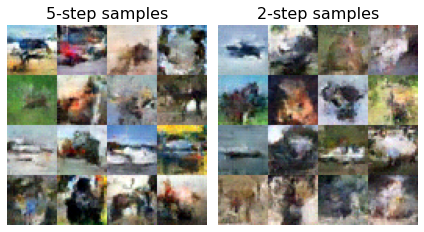

In [7]:
key = jax.random.PRNGKey(43)
shape = (16, 32, 32, 3) 

log_eval_grid(restored_state, score, key, config.consistency, shape, log_wandb=False)
plt.savefig("plots/cifar10_samples.png")